# Network Preparation
- Determine which links should be included for routing
- Create directed edge dataframe
- Format edge and turn attribute variables
- Prepare dictionaries for quick edge attribute access

In [21]:
from pathlib import Path
import time
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
import networkx as nx
from stochopy.optimize import minimize
import stochastic_optimization
from tqdm import tqdm
import similaritymeasures
import random
from shapely.ops import LineString, MultiLineString

import sys
sys.path.insert(0,str(Path.cwd().parent))
import file_structure_setup
config = file_structure_setup.filepaths()

from network.src import modeling_turns, prepare_network
import speedfactor

In [22]:
turns = pd.read_parquet(config['network_fp']/'turns_df.parquet')
links = gpd.read_file(config['network_fp']/'final_network.gpkg',layer='edges')

In [23]:
# #unit conversions
links['length_mi'] = (links['length_ft'] / 5280).round(2)
links['ascent_ft'] = (links['ascent_m'] * 3.28084).round(0)
#links.drop(columns=['length_ft','ascent_m'],inplace=True)

In [24]:
#dicts for referencing certain link attributes quickly
length_dict = dict(zip(links['linkid'],links['length_ft'])) # need this for loss function
geo_dict = dict(zip(links['linkid'],links['geometry']))

## Define which links are permitted for routing

In [25]:
# only allow these types for routing
link_types_allowed = ['bike','pedestrian','road']
links = links[links['link_type'].isin(link_types_allowed)]

# remove isolated links
#links, nodes = prepare_network.largest_comp_and_simplify_fast(links)

In [26]:

# trim the turns dataframe too
highway_dict = dict(zip(links['linkid'],links['link_type']))
turns['source_link_type'] = turns['source_linkid'].map(highway_dict)
turns['target_link_type'] = turns['target_linkid'].map(highway_dict)
del highway_dict
turns = turns[turns['source_link_type'].isin(link_types_allowed) & turns['target_link_type'].isin(link_types_allowed)]

FUTURE: ADD LINKS USED IN MAP MATCHING

# Network Attribute Cleaning
We have these attributes:
- Length
- Grade/Elevation
- Bike Facility
- Oneway
- Signals
- AADT
- Truck %
- Lanes
- Speed Category


## Bike Facilities


In [27]:
links[['facility_fwd','facility_rev']].value_counts()

facility_fwd        facility_rev      
multi use path      multi use path        1851
bike lane           bike lane             1641
sharrow             sharrow                847
bike lane           no facility            581
cycletrack          cycletrack             122
buffered bike lane  buffered bike lane     119
sharrow             bike lane               96
bike lane           sharrow                 91
sharrow             no facility             84
no facility         bike lane               63
cycletrack          no facility             37
buffered bike lane  no facility             22
                    bike lane               19
cycletrack          bike lane               14
bike lane           buffered bike lane       9
no facility         buffered bike lane       8
sharrow             buffered bike lane       2
dtype: int64

In [28]:
# set no facility values to null
links.loc[links['facility_fwd'] == 'no facility','facility_fwd'] = None
links.loc[links['facility_rev'] == 'no facility','facility_rev'] = None

# set sharrow to none
links.loc[links['facility_fwd']=='sharrow','facility_fwd'] = None
links.loc[links['facility_rev']=='sharrow','facility_rev'] = None

# create a single column version for correlation matrix
protection = {
    "cycletrack": 3,
    "buffered bike lane": 2,
    "bike lane": 1,
    "sharrow": 0
}
cond = links['facility_fwd'].map(protection) >= links['facility_rev'].map(protection)
links['bike_facility'] = pd.Series(np.where(cond,links['facility_fwd'],links['facility_rev']))
links.loc[links['bike_facility'].isna(),'bike_facility'] = None
links['bike_facility'].value_counts()
#for correlation testing turn into oridinal variable (increasing protection)
links['bike_facility'] = links['bike_facility'].map(protection)
links.loc[links['bike_facility'].isna(),'bike_facility'] = 0
links['bike_facility'].value_counts()

0.0    75921
1.0      882
2.0       70
3.0       39
Name: bike_facility, dtype: int64

In [29]:
#for right now, just treat multi-use paths and cycletracks as the same?

## Lanes
- All non-road links get a 1 (doing this so lanes attribute isn't being confounded with vehicle access)
- By direction is too detailed, use a per direction estimate (i.e. treat a 5 lane oneway road the same as a 10 lane twoway road or a 5 lane per direction)
- Simplify to:
    - 1 lane per direction
    - 2 lanes per direction
    - 3+ lanes per direction
- If unequal number of lanes use direction that would result in the higher category
    - Example: 10th Street NE would be 2 lanes per direction because it has 2/1 lanes by direction
- Turn lanes (middle, right, etc) are NOT counted in HERE or GDOT

In [30]:
#give every road link a base value of 1
links['lanes'] = 0
links.loc[links['link_type']=='road','lanes'] = 1


if 'here_lanes' in links.columns:

    #if one is null take the null value
    links.loc[links['here_lanes'].isna() & links['gdot_lanes'].notna(),'lanes'] = links['gdot_lanes']
    links.loc[links['here_lanes'].notna() & links['gdot_lanes'].isna(),'lanes'] = links['here_lanes']

    #otherwise choose whichever is smaller
    links.loc[links['here_lanes'].notna() & links['gdot_lanes'].notna(),'lanes'] = links[['here_lanes','gdot_lanes']].min(axis=1)

else:
    links.loc[links['gdot_lanes'].notna(),'lanes'] = links['gdot_lanes']

#TODO figure out what to do when there is a disrepency between the lanes
## Examine where there's a big mismatch between HERE and GDOT
# - There are a couple of cases where GDOT will be way off, like North Highland Ave NE which shows up as having four lanes when it's mostly 2 lanes for most of its length.
# - Memorial Drive is also marked as having four lanes but it was road dieted post 2016, so just use the old value.
# - Unless it's a residential street or a few cases that were identified, use the GDOT values.
#links.loc[links['here_lanes'] != links['gdot_lanes'],['here_lanes','gdot_lanes']].value_counts()
#links.loc[links['here_lanes'] != links['gdot_lanes'],['here_lanes','gdot_lanes','geometry']].explore(style_kwds=style_kwds,**tile_dict)
#links.loc[(links['here_lanes']=='1') & (links['lanes']==4),['highway','name','lanes','here_lanes','geometry']].explore(**tile_dict,style_kwds=style_kwds)

In [31]:
tile_dict = {
    "tiles": "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    "attr": "Google"
}
style_kwds = {
    "weight": 6,
    "color": "white"
}

## Speed

In [32]:
#set all na values to 1 as the base
links['speed'] = 0

if 'here_speed' in links.columns:
    links.loc[links['here_speed'].notna(),'speed'] = links.loc[links['here_speed'].notna(),'here_speed']
    links.loc[links['here_speed'].isna() & (links['link_type']=='road'),'speed'] = 1

## AADT

In [33]:
#set nulls to zero
links.loc[links['AADT'].isna(),'AADT'] = 0
links.loc[links['truck_pct'].isna(),'truck_pct'] = 0

## Grade

In [34]:
#get absolute value
links['descent_grade_%'] = links['descent_grade_%'].abs()

# set maximum possible grade to 30%
links.loc[(links['ascent_grade_%'] > 30),'ascent_grade_%'] = 30
links.loc[(links['descent_grade_%'] > 30),'descent_grade_%'] = 30

#take the max value for the correlation matrix
links['maxgrade_%'] = links[['ascent_grade_%','descent_grade_%']].max(axis=1)

# Network Attribute Analysis
Just apply this to road links for now

In [35]:
links.columns

Index(['A', 'B', 'linkid', 'link_type', 'osmid', 'timestamp', 'version',
       'type', 'highway', 'oneway', 'name', 'bridge', 'tunnel', 'cycleway',
       'service', 'footway', 'sidewalk', 'bicycle', 'foot', 'access', 'area',
       'all_tags', 'geom_type', 'facility_fwd', 'facility_rev', 'year',
       'coa_id', 'improvement', 'route_type', 'gdot_lanes', 'AADT',
       'truck_pct', 'here_speed', 'here_lanes', 'ascent_m', 'ascent_grade_%',
       'descent_m', 'descent_grade_%', 'length_ft', 'geometry', 'length_mi',
       'ascent_ft', 'bike_facility', 'lanes', 'speed', 'maxgrade_%'],
      dtype='object')

In [36]:
correlation_variables = ['bike_facility','AADT','truck_pct','lanes','speed','maxgrade_%','length_ft']
test = links.loc[links['link_type']=='road',correlation_variables]
test
#links[network_variables].value_counts()

,bike_facility,AADT,truck_pct,lanes,speed,maxgrade_%,length_ft
0,0.0,1657.0,0.0,1.0,1.0,3.64,176.381724
1,0.0,0.0,0.0,1.0,1.0,2.20,1112.939536
2,0.0,1657.0,0.0,1.0,2.0,1.99,376.214327
3,0.0,1657.0,0.0,1.0,2.0,7.08,119.767257
4,0.0,1657.0,0.0,1.0,2.0,2.50,374.125553
...,...,...,...,...,...,...,...
153133,0.0,1657.0,0.0,1.0,2.0,0.17,455.114662
153144,0.0,564.0,0.0,1.0,2.0,3.38,306.916534
153152,0.0,564.0,0.0,1.0,2.0,2.83,1153.329184
153154,0.0,28600.0,0.0,2.0,3.0,0.02,27.398752


In [37]:
#links.groupby(['lanes','here_speed']).apply(lambda x: np.round(x.length.sum() / 5280,1)).sort_values(ascending=False)

Correlation Matrix:
               bike_facility      AADT  truck_pct     lanes     speed  \
bike_facility       1.000000  0.001953   0.003093  0.000933  0.003015   
AADT                0.001953  1.000000   0.073193  0.653228  0.471546   
truck_pct           0.003093  0.073193   1.000000  0.069522  0.112117   
lanes               0.000933  0.653228   0.069522  1.000000  0.326119   
speed               0.003015  0.471546   0.112117  0.326119  1.000000   
maxgrade_%         -0.001640 -0.068795  -0.014613 -0.035462 -0.140706   
length_ft          -0.003998 -0.155376  -0.004409 -0.153154 -0.059176   

               maxgrade_%  length_ft  
bike_facility   -0.001640  -0.003998  
AADT            -0.068795  -0.155376  
truck_pct       -0.014613  -0.004409  
lanes           -0.035462  -0.153154  
speed           -0.140706  -0.059176  
maxgrade_%       1.000000   0.179196  
length_ft        0.179196   1.000000  


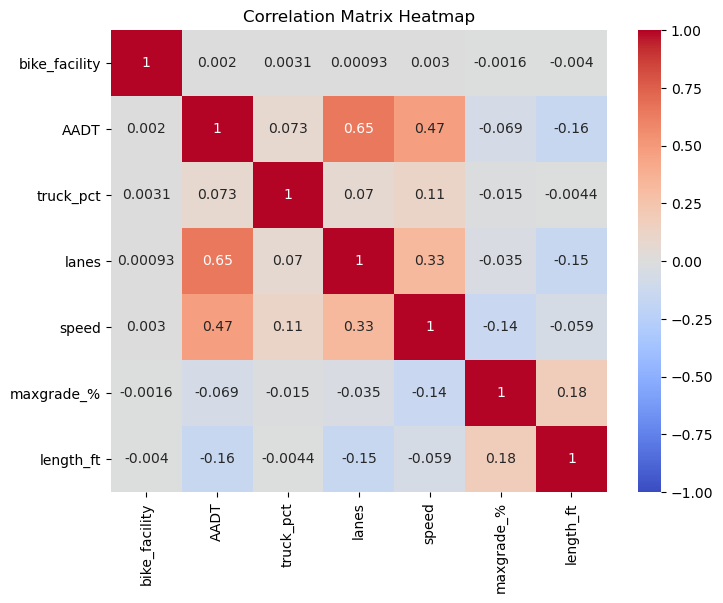

In [38]:
#correlation matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = test.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

Correlation Matrix:
               bike_facility      AADT  truck_pct     lanes     speed  \
bike_facility       1.000000  0.076733  -0.063304  0.016118  0.000872   
AADT                0.076733  1.000000   0.020338  0.632800  0.440328   
truck_pct          -0.063304  0.020338   1.000000  0.009022  0.102047   
lanes               0.016118  0.632800   0.009022  1.000000  0.352741   
speed               0.000872  0.440328   0.102047  0.352741  1.000000   
maxgrade_%          0.003385 -0.046054   0.034071 -0.035987 -0.141399   
length_ft          -0.081547 -0.159709   0.017322 -0.168630 -0.118002   

               maxgrade_%  length_ft  
bike_facility    0.003385  -0.081547  
AADT            -0.046054  -0.159709  
truck_pct        0.034071   0.017322  
lanes           -0.035987  -0.168630  
speed           -0.141399  -0.118002  
maxgrade_%       1.000000   0.165991  
length_ft        0.165991   1.000000  


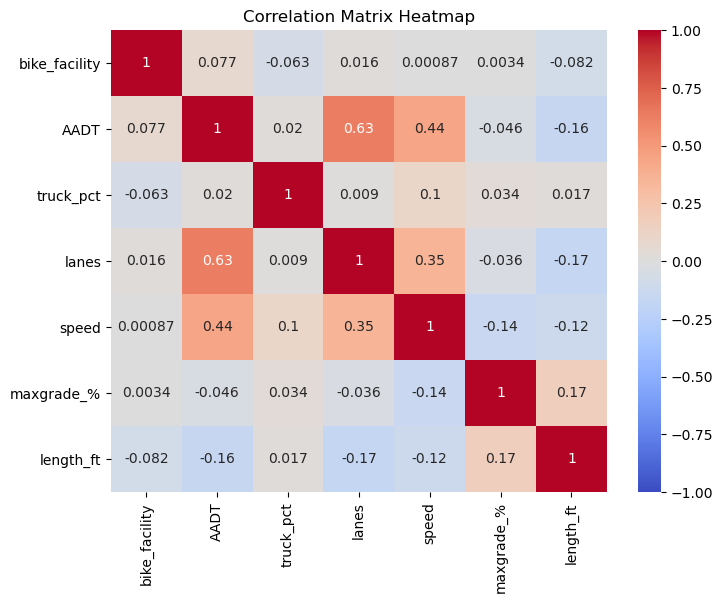

In [39]:
#correlation matrix for roads with bicycle facilities
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a random 80000x3 matrix
# For a real scenario, you would load your data here
#data = links[categorical_variables].values #np.random.rand(80000, 3)

# Convert the data to a pandas DataFrame for easier manipulation
#df = links[['lanes','here_speed']]#pd.DataFrame(data, columns=['Feature1', 'Feature2', 'Feature3'])
df = test[test['bike_facility']>0]

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [40]:
# import numpy as np
# from sklearn.decomposition import PCA

# # Generate a random 80000x3 matrix
# # For a real scenario, you would load your data here
# data = np.random.rand(80000, 3)

# # Initialize PCA
# pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization purposes

# # Fit PCA on the data
# principal_components = pca.fit_transform(data)

# # Display the explained variance ratio
# print("Explained variance ratio:", pca.explained_variance_ratio_)

# # Display the principal components
# print("Principal components shape:", principal_components.shape)

# # Optionally, save the principal components to a file
# np.savetxt("principal_components.csv", principal_components, delimiter=",")

# # Plot the first two principal components if you want to visualize
# import matplotlib.pyplot as plt

# plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('PCA of 80000x3 matrix')
# plt.show()


# Formatting

## Format link attributes

In [41]:
# wasn't able to get major/minor to be significant
#Major/minor road classification to create high traffic stress variable
major_road = ['primary','secondary']
major_road = major_road + [item + '_link' for item in major_road]
minor_road = ['tertiary','unclassified','residential','service','trunk','living_street']
major_road = major_road + [item + '_link' for item in minor_road]
links.loc[links['highway'].isin(major_road),'link_type_new'] = 'major_road'
links.loc[links['highway'].isin(minor_road),'link_type_new'] = 'minor_road'
links.loc[links['link_type_new'].isna(),'link_type_new'] = links.loc[links['link_type_new'].isna(),'link_type']

# links['high_traffic_stress'] = links['link_type_new'] == 'major_road'
links['motorized'] = links['link_type_new'].isin(['major_road','minor_road'])

## Format turn attributes
Only count left and right turns if going from one road to another road.

In [42]:
#sets turns that are not from road to road to None, effectively ignoring them
turns.loc[(turns['source_link_type']!='road') & (turns['target_link_type']!='road'),'turn_type'] = None

#create boolean turn type columns
turns['left'] = turns['turn_type'] == 'left'
turns['right'] = turns['turn_type'] == 'right'
turns['straight'] = turns['turn_type'] == 'straight'

#unsignalized straight/left turn where crossing street is a major road
highway_dict = dict(zip(links['linkid'],links['link_type_new']))
turns['source_link_type'] = turns['source_linkid'].map(highway_dict)
turns['target_link_type'] = turns['target_linkid'].map(highway_dict)
del highway_dict
turns['unsig_major_road_crossing'] = (turns['signalized']==False) & (turns['target_link_type']=='major_road') & (turns['source_link_type']=='minor_road')

## Import directed network

In [43]:
directed_links = pd.read_parquet(config['network_fp']/'directed_edges.parquet')

In [44]:
#merge with links
link_cols_drop = ['ascent_m', 'ascent_grade_%', 'descent_m', 'descent_grade_%']
links.drop(columns=link_cols_drop,inplace=True)
directed_cols_to_add = ['linkid','reverse_link','ascent_m','ascent_grade_%']
links = pd.merge(links,directed_links[directed_cols_to_add])
del directed_links

In [45]:
# reverse bike facilities
links['facility_fwd'] = np.where(links['reverse_link']==True,links['facility_fwd'],links['facility_rev'])
links.drop(columns=['facility_rev'],inplace=True)

In [46]:
# Remove wrongway
oneway_dict = dict(zip(links['linkid'],links['oneway']))
turns['source_oneway'] = turns['source_linkid'].map(oneway_dict)
turns['target_oneway'] = turns['target_linkid'].map(oneway_dict)
del oneway_dict
source_wrongway = ((turns['source_oneway'] == True) & (turns['source_reverse_link'] == True)) == False
target_wrongway = ((turns['target_oneway'] == True) & (turns['target_reverse_link'] == True)) == False
turns = turns[source_wrongway & target_wrongway]

#remove wrongway links
#TODO did we remove these in the export network step too?
links = links.loc[((links['oneway']==True) & (links['reverse_link']==True)) == False]#,'reverse_link'].value_counts()

## Format directed link attributes

In [47]:
#fill in missing NAs for grade
links['ascent_grade_%'] = links['ascent_grade_%'].fillna(0)
#TODO remove negative values from grade %
links['ascent_grade_%'] = links['ascent_grade_%'].abs()
#set any values above X to blank

In [48]:
#links['ascent_grade_%'].describe()
links['above_4'] = links['ascent_grade_%'] > 4

In [49]:
links.loc[links['facility_fwd'].isna() | (links['facility_fwd']=='no facility'),'facility_fwd'] = None

In [50]:
# links['major_road_w_class_2'] = links['facility_fwd'].isin(['bike lane','buffered bike lane']) & (links['link_type_new'] == 'major road')
# links['minor_road_w_class_2'] = links['facility_fwd'].isin(['bike lane','buffered bike lane']) & (links['link_type_new'] == 'minor road')
# links['major_road_no_facil'] = (links['major_road_w_class_2'] == False) & (links['link_type_new'] == 'major road')
# links['minor_road_no_facil'] = (links['minor_road_w_class_2'] == False) & (links['link_type_new'] == 'minor road')

In [51]:
#mixed traffic, no bike lanes
#take sharrow out
links['mixed_traffic_no_facil'] = links['motorized'] & (links['facility_fwd'].isin(['bike lane', 'multi use path','buffered bike lane','cycletrack']) == False)
links['mixed_traffic_w_facil'] = links['motorized'] & (links['facility_fwd'].isin(['bike lane', 'multi use path','buffered bike lane','cycletrack']) == True)

In [52]:
links['mixed_traffic_w_facil']

0         False
1         False
2         False
3         False
4         False
          ...  
153819    False
153820    False
153821    False
153822    False
153823    False
Name: mixed_traffic_w_facil, Length: 144458, dtype: bool

In [53]:
#TODO post GDOT
#add elevation adjusted travel times based on assumed speed on flat ground
speedfactor.calculate_adjusted_speed(links,9)

## Test Columns

In [54]:
# if you use these, you'll just get the shortest path back
links['test_column'] = 0
turns['test_column'] = 0

## Condense attributes


In [55]:
export_links = links[['A', 'B', 'linkid', 'reverse_link', 'link_type', 'osmid',
       'highway', 'oneway', 'name', 'year',
       'AADT', 'truck_pct', 'speed', 'length_ft',
       'lanes', 'link_type_new', 'motorized', 'facility_fwd', 'improvement', 'ascent_ft',
       'ascent_grade_%', 'above_4','mixed_traffic_no_facil', 'mixed_traffic_w_facil',
       'travel_time_min',
       'test_column','length_mi','geometry']]

# Form the turn graph needed for routing from the turns dataframe

In [56]:
# test = set(export_links['linkid'].tolist())
# turns[(turns['source_linkid'].isin(test) == False)|(turns['target_linkid'].isin(test) == False)]

In [57]:
#turn_G = modeling_turns.make_turn_graph(turns)

In [58]:
#export calibration network
with (config['calibration_fp']/"calibration_network.pkl").open('wb') as fh:
    pickle.dump((export_links,turns),fh)